In [1]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import curve_fit
from scipy.odr import *

from astropy.coordinates import SkyCoord
from astropy.time import Time
from skyfield.api import load

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
#---------------------------------------
# Input some parameters from parm_env.ipynb
#---------------------------------------
%run parm_env_all.ipynb

['Ka' 'Ka' 'Q' 'B6' 'B6' 'K' 'B7' 'K' 'Ka' 'B7' 'B6' 'B7' 'B3' 'B6' 'B6'
 'B4' 'B4']


### Fitting the Proper Motion with the parallax

$\alpha(t)$ = $\alpha_{0}$  + $\mu_{\alpha}$ $\cos\delta$ * $(t - t_{0})$ +  $\pi$ $f_{\alpha}$ ($\alpha(t)$, $\delta(t)$, $t$)

$\delta(t)$ = $\delta_{0}\,$  + $\mu_{\delta}$ $\hspace{9mm}$ *  $(t - t_{0}$) +  $\pi$ $f_{\delta}$( $\alpha(t)$, $\delta(t)$, $t$)

$f_{\alpha}$($\alpha(t)$, $\delta(t)$, $t$) = $f_{\alpha}$($\alpha$, $\delta$, $t$) =  ($X \sin\alpha - Y \cos\alpha$) $/ \cos\delta$

$f_{\delta}$($\alpha(t)$, $\delta(t)$, $t$) = $f_{\delta}$($\alpha$, $\delta$, $t$) = $X \cos\alpha\sin\delta + Y \sin\alpha\sin\delta - Z \cos\delta$

- ($f_{\alpha}, f_{\delta}$): the projections of the parallactic ellipse [au] 

- ($X$, $Y$, $Z$): barycentric coordinates of the Earth [au], time dependent

---

y $\hspace{37.5mm}$ = m $\hspace{10.5mm}$ * x $\hspace{9mm}$ + c

$\alpha(t)$ $-$ $\pi$ $f_{\alpha}$($\alpha(t)$, $\delta(t)$, $t$) = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{0}$) + $\alpha_{0}$

$\delta(t)$ $-$ $\pi$ $f_{\delta}$($\alpha(t)$, $\delta(t)$, $t$) = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{0}$) + $\delta_{0}$

In [3]:
# y: corvert the unit of ra and dec from deg to mas
ra_mas_arr          = deg2mas(ra_deg_arr)                 # Right Ascension [mas]
dec_mas_arr         = deg2mas(dec_deg_arr)                # Declination     [mas]
radec_err_mas_arr   = deg2mas(radec_err_deg_arr)          # Uncertainties of RA & Dec [mas]

f_ra_arr, f_dec_arr = get_project_parallactic(ra_deg_arr, dec_deg_arr, time_jd_arr)
prllx_ra_mas_arr    = prllx * f_ra_arr                    # parallax in the direction of ra  [mas]
prllx_dec_mas_arr   = prllx * f_dec_arr                   # parallax in the direction of dec [mas]

ra_minus_prllx_mas_arr  = ra_mas_arr  - prllx_ra_mas_arr  # ra  - parallax_ra  [mas] 
dec_minus_prllx_mas_arr = dec_mas_arr - prllx_dec_mas_arr # dec - parallax_dec [mas] 

# x: calculate the observational time difference [yr]
time_diff_yr_arr  = time_yr_arr - time_yr_std

#----------------------------------------------------
# Set the y & x for the linear regression
y_ra_arr          = drop_arr(ra_minus_prllx_mas_arr, drop_list)           # RA(t) - prllx_ra        [mas]
y_err_ra_arr      = drop_arr(radec_err_mas_arr, drop_list)                # Uncertainties of RA(t)  [mas]
x_ra_arr          = drop_arr(time_diff_yr_arr, drop_list)                 # t - t_0   [yr]

y_dec_arr         = drop_arr(dec_minus_prllx_mas_arr, drop_list)          # Dec(t) - prllx_dec      [mas]
y_err_dec_arr     = drop_arr(radec_err_mas_arr, drop_list)                # Uncertainties of Dec(t) [mas]
x_dec_arr         = drop_arr(time_diff_yr_arr, drop_list)                 # t - t_0   [yr]

wt_y_err_ra_arr   = np.divide(1, y_err_ra_arr)
wt_y_err_dec_arr  = np.divide(1, y_err_dec_arr)

### Linear regression

In [4]:
%%time
###--------------------------------------------------
# linear regression
# Python package numpy.polyfit with order = 1

# (1) RA
ra_m, ra_c, ra_m_err, ra_c_err, ra_chi2, ra_chi2_dof, ra_r = \
get_parm_from_lstqrt_linear(x_ra_arr, y_ra_arr)

# wrighted with the uncertainties of RA
ra_wt_m, ra_wt_c, ra_wt_m_err, ra_wt_c_err, ra_wt_chi2, ra_wt_chi2_dof, ra_wt_r = \
get_parm_from_lstqrt_linear(x_ra_arr, y_ra_arr, wt_y_err_ra_arr)


# (2) Dec
dec_m, dec_c, dec_m_err, dec_c_err, dec_chi2, dec_chi2_dof, dec_r = \
get_parm_from_lstqrt_linear(x_dec_arr, y_dec_arr)

# wrighted with the uncertainties of dec
dec_wt_m, dec_wt_c, dec_wt_m_err, dec_wt_c_err, dec_wt_chi2, dec_wt_chi2_dof, dec_wt_r = \
get_parm_from_lstqrt_linear(x_dec_arr, y_dec_arr, wt_y_err_dec_arr)

CPU times: user 3.57 ms, sys: 419 µs, total: 3.98 ms
Wall time: 2.54 ms


### Set the parameters of the fitting results

In [5]:
#----------------------------------------------------
# Observation
#----------------------------------------------------
# Observational time [year]
t0_yr      = time_yr_arr[1]
tf_yr      = time_yr_arr[-1]
t_std_yr   = time_yr_std

# Time different [yr] from the first fitting plot (JVLA K) btw the reference (ALMA B4)
t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

# uncertainty for ra & dec
err_arcs_arr    = radec_err_arcs_arr
ra_err_sec_arr  = ra_arcs2sec(radec_err_arcs_arr) / np.cos(np.deg2rad(dec_deg_std))

# parallax_ra, parallax_dec
prllx_ra_sec_arr   = ra_arcs2sec(prllx_ra_mas_arr/3600.) / np.cos(np.deg2rad(dec_deg_std))
prllx_dec_arcs_arr = prllx_dec_mas_arr/3600.
    
# obs: ra, dec - parallax
ra_minus_prllx_deg_arr  = mas2deg(ra_minus_prllx_mas_arr)   # [deg]
dec_minus_prllx_deg_arr = mas2deg(dec_minus_prllx_mas_arr)  # [deg]

# [sec], [arcs]
ra_minus_prllx_sec_arr, dec_minus_prllx_arcs_arr = \
radec_degdeg2secacrs_arr(ra_minus_prllx_deg_arr, dec_minus_prllx_deg_arr)  


#----------------------------------------------------
# Fitting result
#----------------------------------------------------
# y = mx + c

# (1)   m: pm_ra, pm_dec

# (1.1) Proper motion in the direction of ra

# unit: [mas yr-1]
pm_ra_fit_masyr             = ra_m           
pm_ra_err_fit_masyr         = ra_m_err       
pm_ra_fit_wt_masyr          = ra_wt_m        
pm_ra_err_fit_wt_masyr      = ra_wt_m_err      

# Limiting floats to two decimal points
pm_ra_fit_masyr_fmt         = float('%.2f' % pm_ra_fit_masyr)
pm_ra_err_fit_masyr_fmt     = float('%.2f' % pm_ra_err_fit_masyr)
pm_ra_fit_wt_masyr_fmt      = float('%.2f' % pm_ra_fit_wt_masyr)
pm_ra_err_fit_wt_masyr_fmt  = float('%.2f' % pm_ra_err_fit_wt_masyr)

pm_ra_fit_secyr             = ra_arcs2sec(pm_ra_fit_masyr* 1e-3)    #* np.cos(np.deg2rad(dec_deg_std))
pm_ra_fit_wt_secyr          = ra_arcs2sec(pm_ra_fit_wt_masyr* 1e-3) #* np.cos(np.deg2rad(dec_deg_std))


# (1.2) Proper motion in the direction of dec

# unit: [mas yr-1]
pm_dec_fit_masyr            = dec_m          
pm_dec_err_fit_masyr        = dec_m_err      
pm_dec_fit_wt_masyr         = dec_wt_m       
pm_dec_err_fit_wt_masyr     = dec_wt_m_err   

# Limiting floats to two decimal points
pm_dec_fit_masyr_fmt        = float('%.2f' % pm_dec_fit_masyr)
pm_dec_err_fit_masyr_fmt    = float('%.2f' % pm_dec_err_fit_masyr)
pm_dec_fit_wt_masyr_fmt     = float('%.2f' % pm_dec_fit_wt_masyr)
pm_dec_err_fit_wt_masyr_fmt = float('%.2f' % pm_dec_err_fit_wt_masyr)

# unit: [arcs yr-1]
pm_dec_fit_arcsyr            = pm_dec_fit_masyr    * 1e-3
pm_dec_fit_wt_arcsyr         = pm_dec_fit_wt_masyr * 1e-3


# (2)   c: ra_0, dec_0

# (2.1) ra_0

# unit: [mas]
ra_0_fit_mas          = ra_c
ra_0_err_fit_mas      = ra_c_err
ra_0_fit_wt_mas       = ra_wt_c
ra_0_err_fit_wt_mas   = ra_wt_c_err

# unit: [deg]  
ra_0_fit_deg        = mas2deg(ra_0_fit_mas)
ra_0_err_fit_deg    = mas2deg(ra_0_err_fit_mas)
ra_0_fit_wt_deg     = mas2deg(ra_0_fit_wt_mas)
ra_0_err_fit_wt_deg = mas2deg(ra_0_err_fit_wt_mas)


# (2.2) dec_0

# unit: [mas]
dec_0_fit_mas          = dec_c
dec_0_err_fit_mas      = dec_c_err
dec_0_fit_wt_mas       = dec_wt_c
dec_0_err_fit_wt_mas   = dec_wt_c_err

# unit: [deg]  
dec_0_fit_deg        = mas2deg(dec_0_fit_mas)
dec_0_err_fit_deg    = mas2deg(dec_0_err_fit_mas)
dec_0_fit_wt_deg     = mas2deg(dec_0_fit_wt_mas)
dec_0_err_fit_wt_deg = mas2deg(dec_0_err_fit_wt_mas)

# (2.3) ra_0 & dec_0

# unit: [sec; arcs]
ra_0_fit_sec, dec_0_fit_arcs       = radec_degdeg2secacrs(ra_0_fit_deg, dec_0_fit_deg)
ra_0_fit_wt_sec, dec_0_fit_wt_arcs = radec_degdeg2secacrs(ra_0_fit_wt_deg, dec_0_fit_wt_deg)

ra_0_err_fit_sec      = ra_sec2arcs(ra_0_err_fit_wt_mas/36e2) * np.cos(np.deg2rad(dec_deg_std))
ra_0_err_fit_wt_sec   = ra_sec2arcs(ra_0_err_fit_wt_mas/36e2) * np.cos(np.deg2rad(dec_deg_std))
dec_0_err_fit_arcs    = dec_0_err_fit_wt_mas/36e2
dec_0_err_fit_wt_arcs = dec_0_err_fit_wt_mas/36e2

### Fitting results

In [6]:
#----------------------------------------------------
# Fitting result
print ('Fitting result:\n')

print ('#------------------------------------------------------')
print ('(1) Without weighting the uncertainties of ra & dec\n')

print ('- Proper motion (RA)  =  {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_ra_fit_masyr, pm_ra_err_fit_masyr))
print ('- Proper motion (Dec) = {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_dec_fit_masyr, pm_dec_err_fit_masyr))
print ('- RA_0  \t      = {0:.2f} +- {1:.2f} [mas]'.format(ra_0_fit_mas , ra_0_err_fit_mas))
print ('- Dec_0 \t      = {0:.2f} +- {1:.2f} [mas]'.format(dec_0_fit_mas, dec_0_err_fit_mas))

print ('\nRA')
print ('- Chi square = {0:.2f}'.format(ra_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(ra_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(ra_r))

print ('\nDec')
print ('- Chi square = {0:.2f}'.format(dec_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(dec_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(dec_r))

print ('\n#------------------------------------------------------')
print ('(2) Weighting the uncertainties of ra & dec\n')

print ('- Proper motion (RA)  =  {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_ra_fit_wt_masyr, pm_ra_err_fit_wt_masyr))
print ('- Proper motion (Dec) = {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_dec_fit_wt_masyr, pm_dec_err_fit_wt_masyr))
print ('- RA_0  \t      = {0:.2f} +- {1:.2f} [mas]'.format(ra_0_fit_wt_mas , ra_0_err_fit_wt_mas))
print ('- Dec_0 \t      = {0:.2f} +- {1:.2f} [mas]'.format(dec_0_fit_wt_mas, dec_0_err_fit_wt_mas))

print ('\nRA')
print ('- Chi square = {0:.2f}'.format(ra_wt_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(ra_wt_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(ra_wt_r))

print ('\nDec')
print ('- Chi square = {0:.2f}'.format(dec_wt_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(dec_wt_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(dec_wt_r))

Fitting result:

#------------------------------------------------------
(1) Without weighting the uncertainties of ra & dec

- Proper motion (RA)  =  12.04 +- 3.84 [mas yr-1]
- Proper motion (Dec) = -13.79 +- 3.83 [mas yr-1]
- RA_0  	      = 188256464.68 +- 9.39 [mas]
- Dec_0 	      = 112412034.85 +- 9.36 [mas]

RA
- Chi square = 858.66
- Chi square / Degree of freedom = 107.33
- Correlation coefficient = 0.58

Dec
- Chi square = 853.32
- Chi square / Degree of freedom = 106.66
- Correlation coefficient = 0.65

#------------------------------------------------------
(2) Weighting the uncertainties of ra & dec

- Proper motion (RA)  =  8.78 +- 1.91 [mas yr-1]
- Proper motion (Dec) = -14.51 +- 1.12 [mas yr-1]
- RA_0  	      = 188256460.20 +- 2.38 [mas]
- Dec_0 	      = 112412034.67 +- 1.40 [mas]

RA
- Chi square = 2.55
- Chi square / Degree of freedom = 0.32
- Correlation coefficient = 0.75

Dec
- Chi square = 0.87
- Chi square / Degree of freedom = 0.11
- Correlation coefficient = 0.96

In [7]:
# Drop the non-fitting obs. for plotting

# time
time_yr_fit_arr  = drop_arr(time_yr_arr , drop_list)
time_ymd_fit_arr = drop_arr(time_ymd_arr , drop_list) 

# ra
ra_minus_prllx_sec_fit_arr  = drop_arr(ra_minus_prllx_sec_arr , drop_list) 

# dec
dec_minus_prllx_arcs_fit_arr = drop_arr(dec_minus_prllx_arcs_arr , drop_list) 
    
# err
ra_err_sec_fit_arr = drop_arr(ra_err_sec_arr , drop_list) 
err_arcs_fit_arr   = drop_arr(err_arcs_arr , drop_list)  

# plot
color_fit_list = drop_arr(color_list , drop_list)
Band_fit_arr   = drop_arr(Band_arr , drop_list)

### Polt the fitting result (with papallax)

In [8]:
%%time
# Input parameter:the initial condition (ALMA B4)
i = -1
ra_ini_deg  = ra_deg_arr[i]       # ra  [deg]
dec_ini_deg = dec_deg_arr[i]      # dec [deg]
time_ini_yr = time_yr_arr[i] + 5  # year start  [yr]
time_fin_yr = time_yr_arr[0] - 5  # year finish [yr]
time_num    = 500                 # Time number btw time_ini & time_fin [#]
time_fit_yr_list = np.linspace(time_ini_yr, time_fin_yr, time_num)
time_fit_diff_yr_list = time_fit_yr_list - time_yr_arr[i]

#----------------------------------------------------
# (1.1) with parallax, without weighting
# Obtain the fitting ra & dec with parallax
ra_fit_deg_arr, dec_fit_deg_arr = get_radec(ra_ini_deg, dec_ini_deg, ra_0_fit_deg, dec_0_fit_deg,
                                            pm_ra_fit_masyr, pm_dec_fit_masyr, prllx, \
                                            time_ini_yr, time_fin_yr, time_num, epsilon= 1e-50)
# Convert the unit from deg to mas
ra_fit_mas_arr  = deg2mas(ra_fit_deg_arr)
dec_fit_mas_arr = deg2mas(dec_fit_deg_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_sec_arr, dec_fit_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_deg_arr, dec_fit_deg_arr)

#----------------------------------------------------
# (1.2) without parallax, without weighting
# Obtain the fitting ra & dec without parallax: e.g., ra-prllx_ra = ra (prllx_ra =0)
ra_fit_wo_prllx_mas_arr       = pm_ra_fit_masyr  * time_fit_diff_yr_list + ra_0_fit_mas
dec_fit_wo_prllx_mas_arr      = pm_dec_fit_masyr * time_fit_diff_yr_list + dec_0_fit_mas
ra_fit_wo_prllx_deg_arr       = mas2deg(ra_fit_wo_prllx_mas_arr)
dec_fit_wo_prllx_deg_arr      = mas2deg(dec_fit_wo_prllx_mas_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_wo_prllx_sec_arr, dec_fit_wo_prllx_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_wo_prllx_deg_arr, dec_fit_wo_prllx_deg_arr)

#----------------------------------------------------
# (2.1) with parallax, with weighting
# Obtain the fit_wtting ra & dec with parallax
ra_fit_wt_deg_arr, dec_fit_wt_deg_arr = get_radec(ra_ini_deg, dec_ini_deg, ra_0_fit_wt_deg, dec_0_fit_wt_deg,
                                            pm_ra_fit_wt_masyr, pm_dec_fit_wt_masyr, prllx, \
                                            time_ini_yr, time_fin_yr, time_num, epsilon= 1e-50)
# Convert the unit from deg to mas
ra_fit_wt_mas_arr  = deg2mas(ra_fit_wt_deg_arr)
dec_fit_wt_mas_arr = deg2mas(dec_fit_wt_deg_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_wt_sec_arr, dec_fit_wt_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_wt_deg_arr, dec_fit_wt_deg_arr)

#----------------------------------------------------
# (2.2) without parallax, with weighting
# Obtain the fit_wtting ra & dec without parallax: e.g., ra-prllx_ra = ra (prllx_ra =0)
ra_fit_wt_wo_prllx_mas_arr       = pm_ra_fit_wt_masyr  * time_fit_diff_yr_list + ra_0_fit_wt_mas
dec_fit_wt_wo_prllx_mas_arr      = pm_dec_fit_wt_masyr * time_fit_diff_yr_list + dec_0_fit_wt_mas
ra_fit_wt_wo_prllx_deg_arr       = mas2deg(ra_fit_wt_wo_prllx_mas_arr)
dec_fit_wt_wo_prllx_deg_arr      = mas2deg(dec_fit_wt_wo_prllx_mas_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_wt_wo_prllx_sec_arr, dec_fit_wt_wo_prllx_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_wt_wo_prllx_deg_arr, dec_fit_wt_wo_prllx_deg_arr)

CPU times: user 24 s, sys: 1.51 s, total: 25.5 s
Wall time: 1min 2s


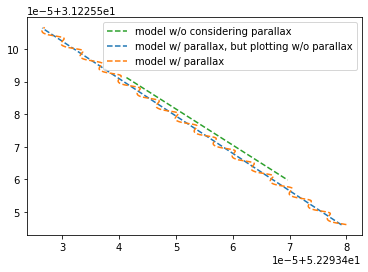

In [9]:
# plot the figure

#----------------------------------------------------
# fitting without pallax
t = np.linspace(-7, 2, 10)

ra_fit_mas_t       = 11.346538177766496  *t + 188256468.08834362
dec_fit_mas_t      = -12.550489771771408 *t + 112412040.51142894
ra_fit_deg_t       = mas2deg(ra_fit_mas_t)
dec_fit_deg_t      = mas2deg(dec_fit_mas_t)

plt.plot(ra_fit_deg_t, dec_fit_deg_t, '--', color='tab:green', label='model w/o considering parallax')

#----------------------------------------------------
# fitting with pallax, plotting without parallax

plt.plot(ra_fit_wo_prllx_deg_arr, dec_fit_wo_prllx_deg_arr, '--', color='tab:blue', label='model w/ parallax, but plotting w/o parallax')

#----------------------------------------------------
# fitting with pallax, plotting with parallax

plt.plot(ra_fit_deg_arr, dec_fit_deg_arr, '--', color='tab:orange', label='model w/ parallax')


plt.legend()
plt.show()

### Plot the fitting results

In [10]:
def plot_ra_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):
    
    # Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
    # a = proper_ra * cos(dec)
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_ra_arr):

        # x: t - t0 [yr]
        time_yr       = time_yr_fit_arr[i]

        # y: RA(t) - parallax_ra [sec]
        ra_minus_prllx_sec = ra_minus_prllx_sec_fit_arr[i]    
        # uncertainty for ra [sec]
        ra_err_sec       = ra_err_sec_fit_arr[i]

        # plot
        ax.errorbar(x    = time_yr, \
                    y    = ra_minus_prllx_sec, \
                    yerr = ra_err_sec, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time [yr]
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
    t_shift = t + time_yr_std

    # y = a                  * x + b
    # y = proper_ra*cos(dec) * x + ra_0 = RA(t) - parallax_ra [sec]
    ra_fit_minus_prllx_sec = fit_m*t + fit_c

    # plot the fitting result
    ax.plot(t_shift, ra_fit_minus_prllx_sec, '--' ,color='tab:blue', label='model w/  parallax')

    # Set the figure
    # ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('Epoch [yr]', fontsize=12)
    ax.set_ylabel(r'$\alpha$ (from %sh$\,$%ss) $-$ $\pi\,f_{\alpha}$ [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
    ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='lower left')

    plt.savefig(plot_savefig_name)
    plt.show()

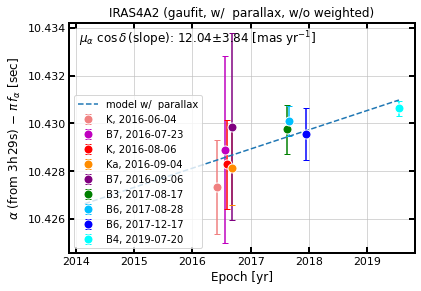

In [11]:
fit_m = pm_ra_fit_secyr
fit_c = ra_0_fit_sec
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeRA_with_prllx.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_masyr_fmt

plot_ra_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

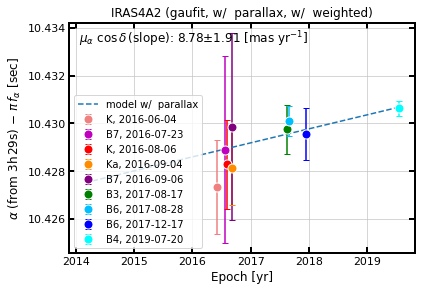

In [12]:
fit_m = pm_ra_fit_wt_secyr
fit_c = ra_0_fit_wt_sec
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/  weighted)'
plot_savefig_name  = '%s4A2_TimeRA_with_prllx_wt.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_wt_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_wt_masyr_fmt

plot_ra_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [13]:
def plot_dec_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):
    # Plot the fitting result (Proper_Dec v.s. Time)
    # a = proper_dec
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_dec_arr):

        # x: t - t0 [yr]
        time_yr       = time_yr_fit_arr[i]

        # y: Dec(t) - parallax_dec [arcs]
        dec_minus_prllx_arcs = dec_minus_prllx_arcs_fit_arr[i]
        # uncertainty for dec [arcs]
        err_arcs      = err_arcs_fit_arr[i]

        ax.errorbar(x    = time_yr, \
                    y    = dec_minus_prllx_arcs, \
                    yerr = err_arcs, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
    t_shift = t + time_yr_std

    # y = m          * x + c
    # y = proper_dec * x + dec_0
    dec_fit_minus_prllx_sec = fit_m*t + fit_c
    
    # plot the fitting result
    ax.plot(t_shift, dec_fit_minus_prllx_sec, '--',color='tab:blue', label='model w/  parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('Epoch [yr]', fontsize=12)
    ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') $-$ $\pi\,f_{\delta}$ [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
    ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend()

    plt.savefig(plot_savefig_name)
    plt.show()

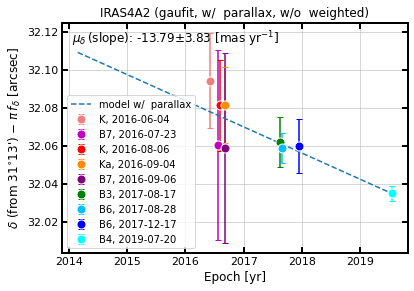

In [14]:
fit_m = pm_dec_fit_arcsyr
fit_c = dec_0_fit_arcs
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/o  weighted)'
plot_savefig_name  = '%s4A2_TimeDec_with_prllx.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_masyr_fmt

plot_dec_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

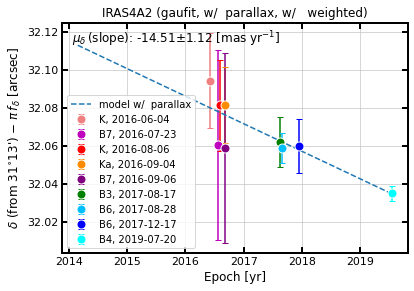

In [15]:
fit_m = pm_dec_fit_wt_arcsyr
fit_c = dec_0_fit_wt_arcs
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/   weighted)'
plot_savefig_name  = '%s4A2_TimeDec_with_prllx_wt.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_wt_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_wt_masyr_fmt

plot_dec_minus_prllx_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [16]:
def plot_ra_dec(fit_ra_wo_prllx_sec, fit_dec_wo_prllx_arcs, fit_ra_sec, fit_dec_arcs, \
                pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name): 
    
    
    # Plot the fitting result (RA v.s. Dec)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

    #---------------------------------------
    # Plot the observations
    for i, band in enumerate(Band_arr):

        # x: ra  [sec]
        ra_sec        = ra_s_arr[i]  
        # y: dec [arcs]
        dec_arcs      = dec_s_arr[i]  
        # uncertainty for the coordinate
        err_arcs      = radec_err_arcs_arr[i]
        ra_err_sec    = ra_err_sec_arr[i]
        
        markeredgecolor = 'w' if i in drop_list else 'k'

        ax.errorbar(x    = ra_sec,\
                    y    = dec_arcs,\
                    xerr = ra_err_sec,\
                    yerr = err_arcs ,\
                    fmt='o', color = color_list[i],\
                    alpha=0.8, markersize=9, markeredgecolor=markeredgecolor, markeredgewidth=1, capsize=3,\
                    label=band+', '+time_ymd_arr[i])

        #---------------------------------------
        # Plot the fitting result with corresponding observation time     

        # find the nearst time from the time_yr_plot_list
        idx, out_value = find_nearest(time_fit_yr_list, time_yr_arr[i])

        # (1) without parallax   
        # x: ra(t) - parallax_ra  [sec]
        ra_fit_wo_prllx_sec        = fit_ra_wo_prllx_sec[idx]

        # y: dec(t) - parallax_dec [arcs]
        dec_fit_wo_prllx_arcs      = fit_dec_wo_prllx_arcs[idx]

        #ax.plot(ra_fit_wo_prllx_sec, dec_fit_wo_prllx_arcs, color = color_list[i], alpha= 0.8, \
        #        marker='o', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10) 

        #(2)
        # x: ra(t)  [sec]
        ra_fit_sec     = fit_ra_sec[idx]
        # y: dec(t) [arcs]
        dec_fit_arcs   = fit_dec_arcs[idx]

        #ax.plot(ra_fit_sec, dec_fit_arcs, color = color_list[i], alpha= 0.8, \
        #        marker='s', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10)

    #---------------------------------------
    # plot the fitting result

    # plotting without parallax
    ax.plot(fit_ra_wo_prllx_sec, fit_dec_wo_prllx_arcs, '--', color='tab:blue', label='model w/ parallax, \nbut plotting w/o parallax')

    # plotting with parallax
    ax.plot(fit_ra_sec, fit_dec_arcs, '--', color='tab:red', label='model w/  parallax')

    #---------------------------------------
    # Set the figure
    ax.set_title(plot_title_name, fontsize=14)
    ax.set_xlabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=14)
    ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=14)
    ax.set_xlim(10.435, 10.42)
    ax.set_ylim(32.0, 32.25)

    ax.text(0.02, 0.96, r'$\mu_{\alpha}$ $\cos\,\delta\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_ra_fmt, pm_ra_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.02, 0.92, r'$\mu_{\delta}\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_dec_fmt, pm_dec_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='upper right')

    plt.savefig(plot_savefig_name)
    plt.show()

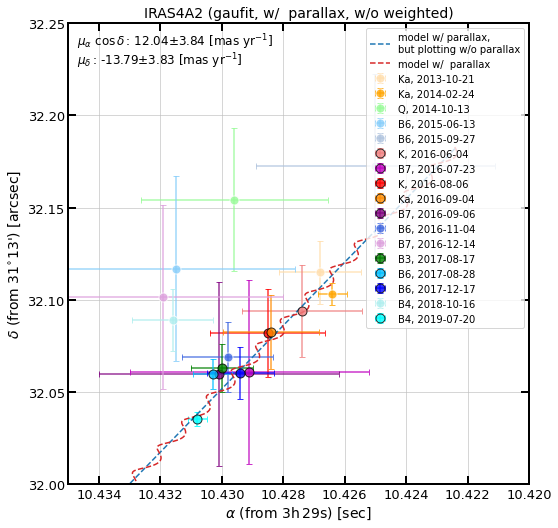

In [17]:
fit_ra_wo_prllx_sec   = ra_fit_wo_prllx_sec_arr
fit_dec_wo_prllx_arcs = dec_fit_wo_prllx_arcs_arr
fit_ra_sec            = ra_fit_sec_arr
fit_dec_arcs          = dec_fit_arcs_arr

pm_ra_fmt      = pm_ra_fit_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_masyr_fmt
pm_dec_fmt     = pm_dec_fit_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_masyr_fmt

plot_title_name   = 'IRAS4A2 (gaufit, w/  parallax, w/o weighted)'
plot_savefig_name = '%s4A2_radec_with_prllx.pdf'%(path_figure)

plot_ra_dec(fit_ra_wo_prllx_sec, fit_dec_wo_prllx_arcs, fit_ra_sec, fit_dec_arcs, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name)

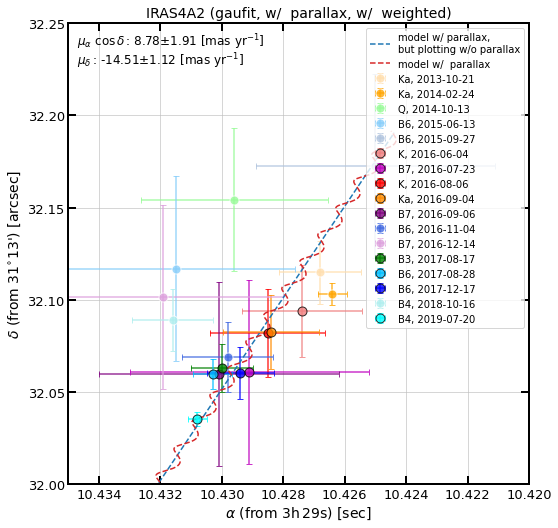

In [18]:
fit_ra_wo_prllx_sec   = ra_fit_wt_wo_prllx_sec_arr
fit_dec_wo_prllx_arcs = dec_fit_wt_wo_prllx_arcs_arr
fit_ra_sec            = ra_fit_wt_sec_arr
fit_dec_arcs          = dec_fit_wt_arcs_arr

pm_ra_fmt      = pm_ra_fit_wt_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_wt_masyr_fmt
pm_dec_fmt     = pm_dec_fit_wt_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_wt_masyr_fmt

plot_title_name   = 'IRAS4A2 (gaufit, w/  parallax, w/  weighted)'
plot_savefig_name = '%s4A2_radec_with_prllx_wt.pdf'%(path_figure)

plot_ra_dec(fit_ra_wo_prllx_sec, fit_dec_wo_prllx_arcs, fit_ra_sec, fit_dec_arcs, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name)

In [19]:
def plot_ra_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):
    
    # Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
    # a = proper_ra * cos(dec)
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    # x: t - t0
    # y: RA(t)
    for i, elm in enumerate(x_ra_arr):

        y_ra_diff = (y_ra_arr[i] - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))

        ax.errorbar(x    = x_ra_arr[i], \
                    y    = y_ra_diff, \
                    yerr = y_err_ra_arr[i], \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

    # y = a                  * x + b
    # y = proper_ra*cos(dec) * x + ra_0
    y_ra_fit      = fit_m*t + fit_c
    y_ra_fit_diff = (y_ra_fit - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))

    # plot the fitting result
    ax.plot(t, y_ra_fit_diff, '--', color='tab:blue', label='model w/ parallax')

    # Set the figure
    # ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
    ax.set_ylabel(r'$\Delta\,$[$\alpha$ (from %sh$\,$%ss) $-$ $\pi\,f_{\alpha}$] [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
    ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    
    #ax.set_xlim(40, -80)
    ax.set_ylim(-80, 40)


    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='lower left')

    plt.savefig(plot_savefig_name)
    plt.show()

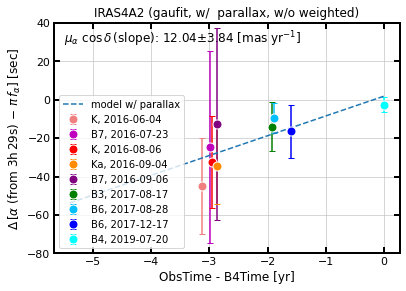

In [20]:
fit_m = pm_ra_fit_masyr
fit_c = ra_0_fit_mas
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeRA_with_prllx_mas.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_masyr_fmt

plot_ra_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

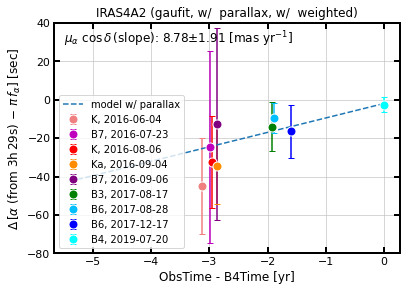

In [21]:
fit_m = pm_ra_fit_wt_masyr
fit_c = ra_0_fit_wt_mas
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/  weighted)'
plot_savefig_name  = '%s4A2_TimeRA_with_prllx_mas_wt.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_wt_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_wt_masyr_fmt

plot_ra_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [22]:
def plot_dec_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):
    
    # Plot the fitting result (Proper_Dec v.s. Time)
    # a = proper_dec
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_dec_arr):

        # x: t - t0
        # y: RA(t)    
        y_dec_diff = y_dec_arr[i] - dec_mas_std

        ax.errorbar(x    = x_dec_arr[i], \
                    y    = y_dec_diff, \
                    yerr = y_err_dec_arr[i], \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

    # y = a          * x + b
    # y = proper_dec * x + dec_0
    y_dec_fit = fit_m*t + fit_c
    y_dec_fit_diff = y_dec_fit - dec_mas_std

    # plot the fitting result
    ax.plot(t, y_dec_fit_diff, '--', color='tab:blue', label='model w/  parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
    ax.set_ylabel(r"$\Delta\,$[$\delta$ (from %s$^{\circ}$%s') $-$ $\pi\,f_{\delta}$] [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
    ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    #ax.set_xlim(40, -80)
    ax.set_ylim(-40, 80)

    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend()

    plt.savefig(plot_savefig_name)
    plt.show()

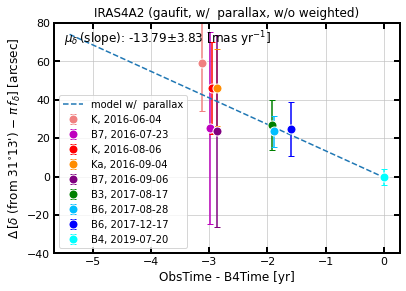

In [23]:
fit_m = pm_dec_fit_masyr
fit_c = dec_0_fit_mas
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeDec_with_prllx_mas.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_masyr_fmt

plot_dec_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

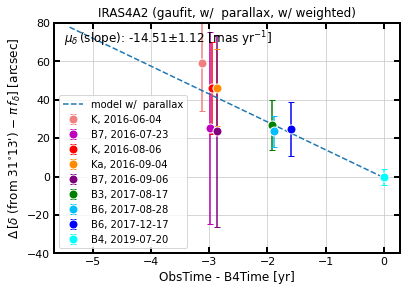

In [24]:
fit_m = pm_dec_fit_wt_masyr
fit_c = dec_0_fit_wt_mas
plot_title_name    = 'IRAS4A2 (gaufit, w/  parallax, w/ weighted)'
plot_savefig_name  = '%s4A2_TimeDec_with_prllx_mas_wt.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_wt_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_wt_masyr_fmt

plot_dec_minus_prllx_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [25]:
def plot_ra_dec_mas(fit_ra_wo_prllx_mas, fit_dec_wo_prllx_mas, fit_ra_mas, fit_dec_mas, \
                    pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name):
    
    # Plot the fitting result (RA v.s. Dec)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

    #---------------------------------------
    # Plot the observations
    for i, band in enumerate(Band_arr):

        # ra & dec difference between each and the standard (B4) obs.
        ra_diff_mas  = (ra_mas_arr[i]  - ra_mas_std ) * np.cos(np.deg2rad(dec_deg_std))
        dec_diff_mas = dec_mas_arr[i]  - dec_mas_std
        # uncertainty for the coordinate
        err_mas      = radec_err_mas_arr[i]   

        markeredgecolor = 'w' if i in drop_list else 'k'
        
        ax.errorbar(x    = ra_diff_mas,\
                    y    = dec_diff_mas,\
                    xerr = err_mas,\
                    yerr = err_mas,\
                    fmt='o', color = color_list[i],\
                    alpha=0.8, markersize=9, markeredgecolor=markeredgecolor, markeredgewidth=2, capsize=3,\
                    label=band+', '+time_ymd_arr[i])

        #---------------------------------------
        # Plot the fitting result with corresponding observational time 

        # find the nearst time from the time_yr_plot_list
        idx, out_value = find_nearest(time_fit_yr_list, time_yr_arr[i])

        # (1) without parallax
        # x: ra(t) - parallax_ra  [mas]
        ra_fit_wo_prllx_mas       = fit_ra_wo_prllx_mas[idx]
        ra_fit_wo_prllx_diff_mas  = (ra_fit_wo_prllx_mas - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))

        # y: dec(t) [mas]
        dec_fit_wo_prllx_mas      = fit_dec_wo_prllx_mas[idx]
        dec_fit_wo_prllx_diff_mas = (dec_fit_wo_prllx_mas - dec_mas_std)

        # plot
        #ax.plot(ra_fit_wo_prllx_diff_mas, dec_fit_wo_prllx_diff_mas, color = color_list[i], alpha= 0.8, \
        #        marker='o', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10)   

        # (2) with parallax
        # x: ra(t)  [mas]
        ra_fit_mas      = fit_ra_mas[idx]
        ra_fit_diff_mas = (ra_fit_mas - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))

        # y: dec(t) [mas]
        dec_fit_mas      = fit_dec_mas[idx]
        dec_fit_diff_mas = dec_fit_mas - dec_mas_std

        # plot
        ax.plot(ra_fit_diff_mas, dec_fit_diff_mas, color = color_list[i], alpha= 0.8, \
                marker='s', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10)

    #---------------------------------------
    # plot the fitting result

    ra_fit_wo_prllx_diff_mas_arr  = (fit_ra_wo_prllx_mas  - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    dec_fit_wo_prllx_diff_mas_arr = fit_dec_wo_prllx_mas  - dec_mas_std
    ra_fit_diff_mas_arr           = (fit_ra_mas           - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    dec_fit_diff_mas_arr          = fit_dec_mas           - dec_mas_std

    # plotting without parallax
    plt.plot(ra_fit_wo_prllx_diff_mas_arr, dec_fit_wo_prllx_diff_mas_arr, \
             '--', color='tab:blue', label='model w/ parallax, \nplotting w/o parallax')

    # plotting with parallax
    ax.plot(ra_fit_diff_mas_arr, dec_fit_diff_mas_arr, '--', color='tab:red', label='model w/  parallax')

    #---------------------------------------
    # Set the figure
    ax.set_title(plot_title_name, fontsize=14)
    ax.set_xlabel(r'$\Delta\,\alpha$ [mas]', fontsize=14)
    ax.set_ylabel(r'$\Delta\,\delta$ [mas]', fontsize=14)
    ax.set_xlim(25, -125)
    ax.set_ylim(-25, 200)

    ax.text(0.02, 0.96, r'$\mu_{\alpha}$ $\cos\,\delta\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_ra_fmt, pm_ra_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.02, 0.92, r'$\mu_{\delta}\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_dec_fmt, pm_dec_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='upper right')

    plt.savefig(plot_savefig_name)
    plt.show()

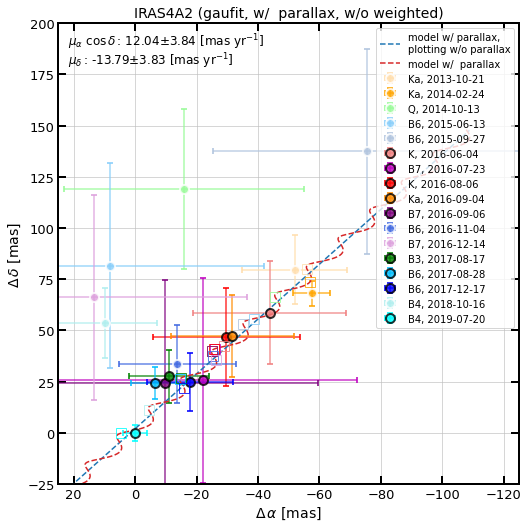

In [26]:
fit_ra_wo_prllx_mas  = ra_fit_wo_prllx_mas_arr
fit_dec_wo_prllx_mas = dec_fit_wo_prllx_mas_arr
fit_ra_mas           = ra_fit_mas_arr
fit_dec_mas          = dec_fit_mas_arr


pm_ra_fmt      = pm_ra_fit_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_masyr_fmt
pm_dec_fmt     = pm_dec_fit_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_masyr_fmt

plot_title_name   = 'IRAS4A2 (gaufit, w/  parallax, w/o weighted)'
plot_savefig_name = '%s4A2_radec_with_prllx_mas.pdf'%(path_figure)

plot_ra_dec_mas(fit_ra_wo_prllx_mas, fit_dec_wo_prllx_mas, fit_ra_mas, fit_dec_mas, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name)

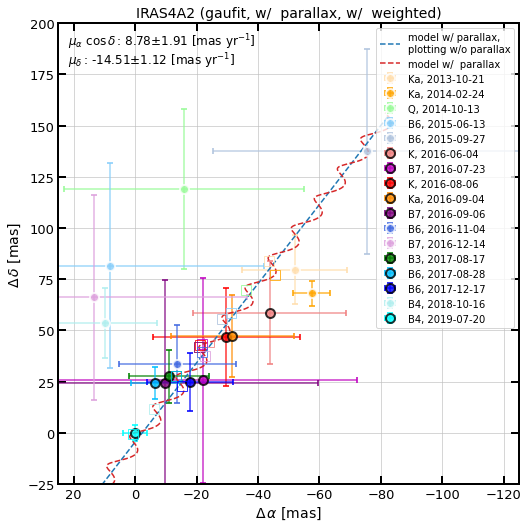

In [27]:
fit_ra_wo_prllx_mas  = ra_fit_wt_wo_prllx_mas_arr
fit_dec_wo_prllx_mas = dec_fit_wt_wo_prllx_mas_arr
fit_ra_mas           = ra_fit_wt_mas_arr
fit_dec_mas          = dec_fit_wt_mas_arr

pm_ra_fmt      = pm_ra_fit_wt_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_wt_masyr_fmt
pm_dec_fmt     = pm_dec_fit_wt_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_wt_masyr_fmt

plot_title_name   = 'IRAS4A2 (gaufit, w/  parallax, w/  weighted)'
plot_savefig_name = '%s4A2_radec_with_prllx_mas_wt.pdf'%(path_figure)

plot_ra_dec_mas(fit_ra_wo_prllx_mas, fit_dec_wo_prllx_mas, fit_ra_mas, fit_dec_mas, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, plot_title_name, plot_savefig_name)

In [28]:
mm1 = SkyCoord('03h29m10.429s', '+31d13m32.08s')
mm2 = SkyCoord('03h29m10.431s', '+31d13m32.04s')

ra_offset  = (mm2.ra - mm1.ra) * np.cos(mm1.dec.to('radian'))
dec_offset = (mm2.dec - mm1.dec)
print (ra_offset.to('arcsec'), dec_offset.to('arcsec'))

0.025654arcsec -0.04arcsec
